<a href="https://colab.research.google.com/github/maimunul/Bengali-Hate-Speech-Detection-using-ML-DL/blob/main/CNN_based_Teacher_To_Student_T10_RMSE_MSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Distillation (Model Compression )
**Date created:** 11/26/2023<br>

Author Name: Maimunul Karim Jisan (https://github.com/maimunul)<br>
University ID: 201001312<br>
Department: CSE<br>
East Delta University<br>
Chittagong, Bangladesh


## Introduction to Rice Leaf Disease Classification using Knowledge Distillation
The main purpose for this project refers to a set of techniques and methodologies aimed at reducing the size of deep learning models, making them more lightweight and efficient while preserving their predictive performance. This is particularly important for deploying models on resource-constrained environments such as mobile devices, edge devices, or in situations where bandwidth is limited.There are several technique available but we choose **Knowledge Distillation Technique** to reduce large model size.<br>

**Knowledge Distillation:** Training a smaller "student" model to mimic the behavior of a larger "teacher" model. The smaller model tries to reproduce the predictions and uncertainty estimates of the larger model.<br><br>

To evacute **Knowledge Distillation** using **Rice Leaf Disease Dataset** from Mendeley Data. Here dataset contain 5932 images with four different rice leaf disease. For example,

Bacterialblight Disease<br>
Blast Disease<br>
Brownspot Disease<br>
Tungro Disease<br>
The dataset contain Train, Test & Validation Images

**Teacher** Model Accuracy is almost 99% on Test Images<br>
Getting **Studen**t model accuracy is 80% on Test Images<br>
After **Knowledge Distillation** Student model accuracy improve: **92.94%** & student_loss: **0.2099**

## Introduction to Knowledge Distillation

Knowledge Distillation is a procedure for model
compression, in which a small (student) model is trained to match a large pre-trained
(teacher) model. Knowledge is transferred from the teacher model to the student
by minimizing a loss function, aimed at matching softened teacher logits as well as
ground-truth labels.

The logits are softened by applying a "temperature" scaling function in the softmax,
effectively smoothing out the probability distribution and revealing
inter-class relationships learned by the teacher.

**Reference:**

- [Hinton et al. (2015)](https://arxiv.org/abs/1503.02531)

# Setup

In [1]:
import tensorflow as tf
import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Data Acquisation and Augmentation

In [2]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# from google.colab import files
# files.upload()


In [3]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d 'maimunulkjisan/rice-leaf-datasettrain-test-and-valid'


rice-leaf-datasettrain-test-and-valid.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile
import os

# Specify the path to the downloaded zip file
zip_file_path = '/content/rice-leaf-datasettrain-test-and-valid.zip'

# Specify the directory where you want to extract the files
extracted_dir_path = '/content/rice_leaf_dataset'

# Create the directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# List the contents of the extracted directory
extracted_files = os.listdir(extracted_dir_path)
print("Extracted files:", extracted_files)


Extracted files: ['val', 'train', 'test']


In [6]:
Input_Image = 256
Channels = 3
batch_size = 32

# Data augmentation for training set
train_data = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

# Training set
train_set = train_data.flow_from_directory(
    r"/content/rice_leaf_dataset/train",
    target_size=(Input_Image, Input_Image),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True
)

# Validation and test sets
common_data = ImageDataGenerator(rescale=1./255)

test_set = common_data.flow_from_directory(
    r"/content/rice_leaf_dataset/test",
    target_size=(Input_Image, Input_Image),
    batch_size=batch_size,
    class_mode='categorical'
)

val_set = common_data.flow_from_directory(
    r"/content/rice_leaf_dataset/val",
    target_size=(Input_Image, Input_Image),
    batch_size=batch_size,
    class_mode='categorical'
)
# Input shape
input_shape = (Input_Image, Input_Image, Channels)

Found 4745 images belonging to 4 classes.
Found 595 images belonging to 4 classes.
Found 592 images belonging to 4 classes.


# **Knowledge Distillation**

In [7]:

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=10,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def call(self, inputs, training=False):
        # Forward pass of teacher
        teacher_predictions = self.teacher(inputs, training=False)

        # Forward pass of student
        student_predictions = self.student(inputs, training=training)

        return student_predictions

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"loss" : loss,"student_loss": student_loss, "distillation_loss": distillation_loss}
        )

        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


# Teacher Model Architecture & Train & Plotting Curve & Confusion Metrics

19/19 [==============================] - 5s 161ms/step - loss: 0.0710 - accuracy: 0.9916
Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        18496     
                                    

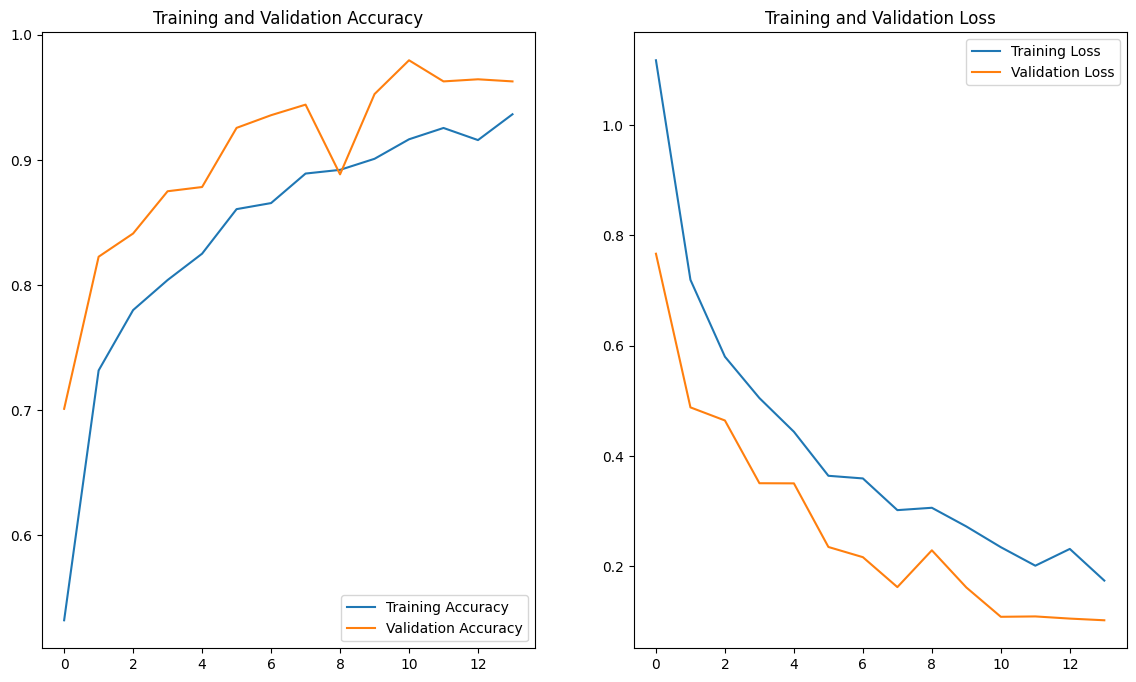

In [8]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

teacher = tf.keras.models.load_model('/content/drive/MyDrive/riceleafdataset/CNNBasedTeacher-CNNBasedStudent/BestTeacher.h5')

teacher.evaluate(test_set)
teacher.summary()

import json

history_path = '/content/drive/MyDrive/riceleafdataset/CNNBasedTeacher-CNNBasedStudent/Best_Teacher_history.json'
# Load the saved history
with open(history_path, 'r') as history_file:
    loaded_history = json.load(history_file)

# Access the metrics from the loaded history
print("Training Loss:", loaded_history['loss'])
print("Validation Loss:", loaded_history['val_loss'])
# Similarly, access other metrics like accuracy, etc.
print("Training Accuracy:", loaded_history['accuracy'])
print("Validation Accuracy:", loaded_history['val_accuracy'])


acc = loaded_history['accuracy']
val_acc = loaded_history['val_accuracy']

loss = loaded_history['loss']
val_loss = loaded_history['val_loss']


# Access the metrics from the loaded history
training_loss = loaded_history['loss']
validation_loss = loaded_history['val_loss']

epochs = len(acc)
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


19/19 [==============================] - 0s 21ms/step - loss: 0.0710 - accuracy: 0.9916
Test Acc: 0.9915966391563416
19/19 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       159
           1       1.00      0.97      0.98       144
           2       0.99      1.00      0.99       160
           3       1.00      1.00      1.00       132

    accuracy                           0.99       595
   macro avg       0.99      0.99      0.99       595
weighted avg       0.99      0.99      0.99       595



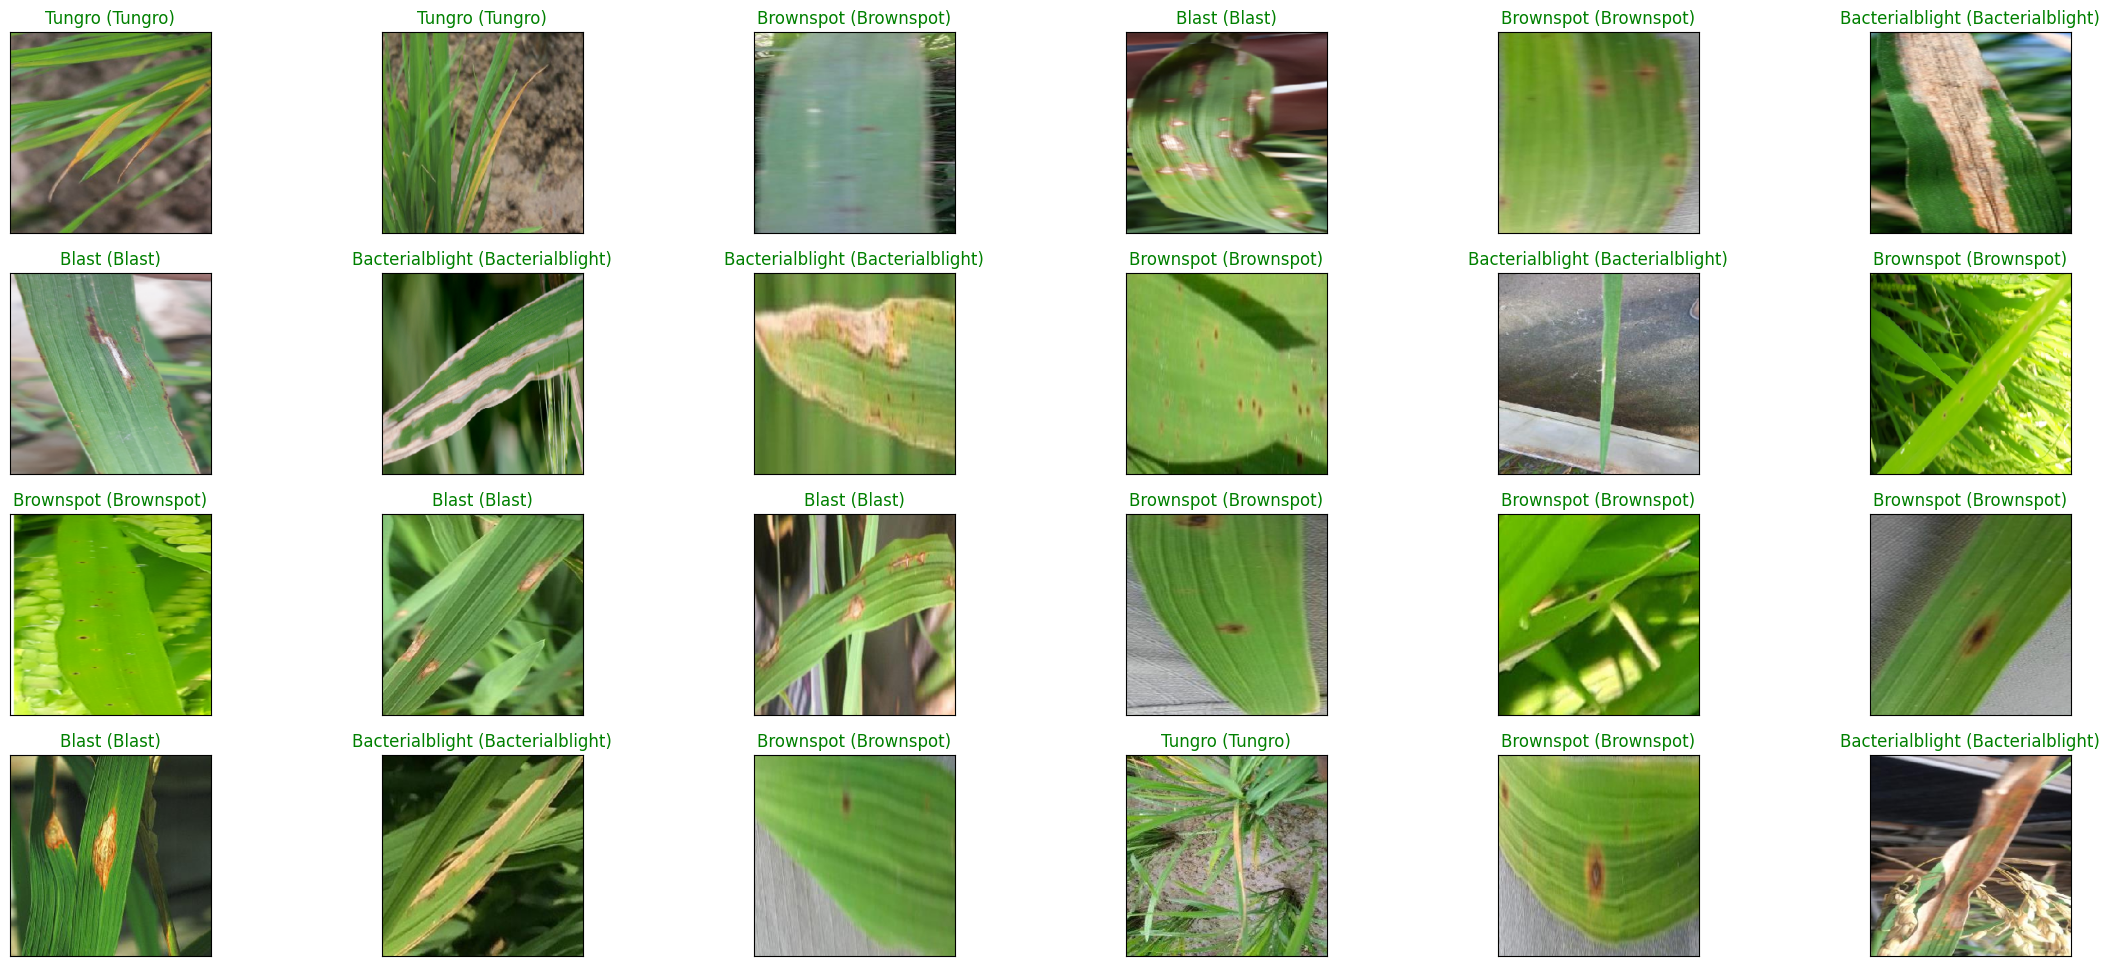

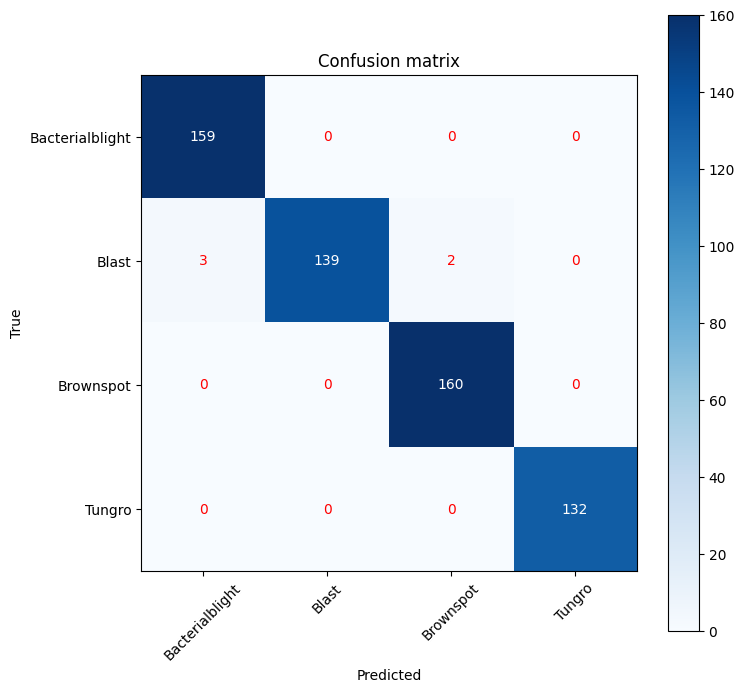

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def extract_data(generator):
    data_list = []
    labels_list = []
    for _ in range(generator.__len__()):
        data, labels = generator.next()
        data_list.append(data)
        labels_list.append(labels)
    x = np.vstack(data_list)
    y = np.vstack(labels_list)
    return x, y

x_train, y_train = extract_data(train_set)
x_test, y_test = extract_data(test_set)

loss = teacher.evaluate(x_test,y_test)
print("Test Acc: " + str(loss[1]))
preds = teacher.predict(x_test)
y_pred = np.argmax(preds , axis = 1 )
label_dict = {0 : 'Bacterialblight', 1 : 'Blast', 2 : 'Brownspot', 3 : 'Tungro'}

figure = plt.figure(figsize=(28, 12))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))
# Generate classification report
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred)
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

classes = list(label_dict.values())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Print the confusion matrix values on each cell
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='red' if i != j else 'white')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Student Model Architecture & Plotting Curve & Confusion Metrics

19/19 [==============================] - 3s 103ms/step - loss: 0.4975 - accuracy: 0.8000
Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 16)      9232      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 61504)             0         
                                    

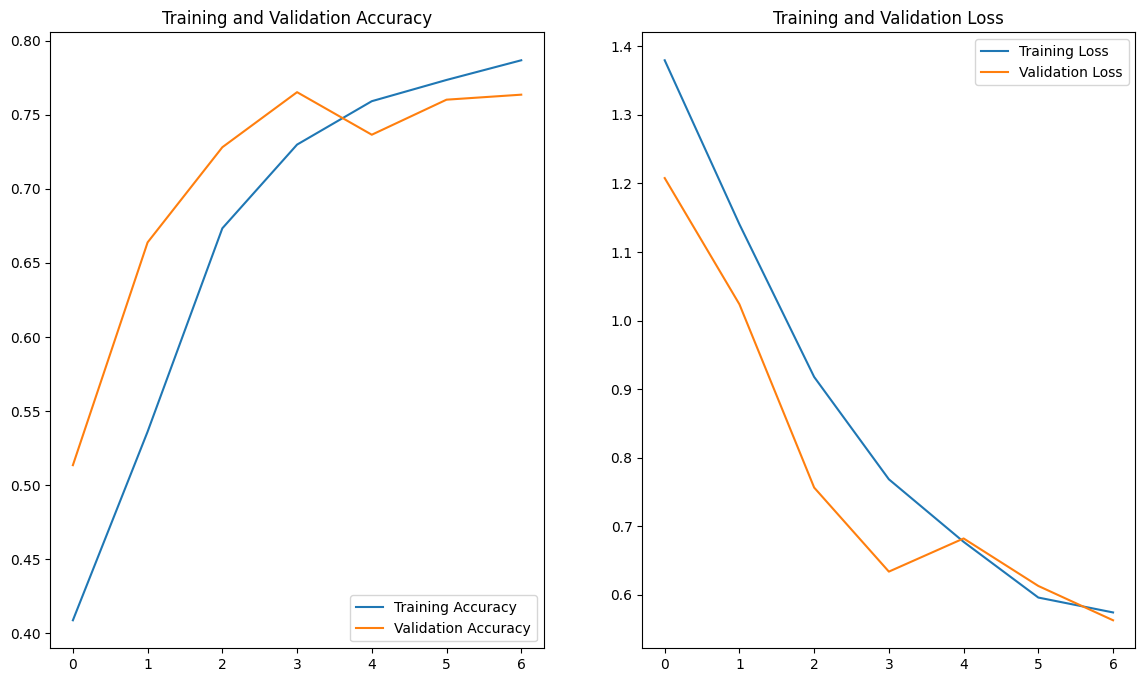

In [9]:
from tensorflow.keras import models

student = tf.keras.models.load_model('/content/drive/MyDrive/riceleafdataset/CNNBasedTeacher-CNNBasedStudent/WorstStudent.h5')
# Clone student for later comparison
student_scratch = tf.keras.models.clone_model(student)
# Train student as done usually using data generator
student_scratch.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
student.evaluate(test_set)
student.summary()

import json

history_path = '/content/drive/MyDrive/riceleafdataset/CNNBasedTeacher-CNNBasedStudent/Worst_Student_history.json'
# Load the saved history
with open(history_path, 'r') as history_file:
    loaded_history = json.load(history_file)

# Access the metrics from the loaded history
print("Training Loss:", loaded_history['loss'])
print("Validation Loss:", loaded_history['val_loss'])
# Similarly, access other metrics like accuracy, etc.
print("Training Accuracy:", loaded_history['accuracy'])
print("Validation Accuracy:", loaded_history['val_accuracy'])


acc = loaded_history['accuracy']
val_acc = loaded_history['val_accuracy']

loss = loaded_history['loss']
val_loss = loaded_history['val_loss']


# Access the metrics from the loaded history
training_loss = loaded_history['loss']
validation_loss = loaded_history['val_loss']

epochs = len(acc)
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, classification_report

# def extract_data(generator):
#     data_list = []
#     labels_list = []
#     for _ in range(generator.__len__()):
#         data, labels = generator.next()
#         data_list.append(data)
#         labels_list.append(labels)
#     x = np.vstack(data_list)
#     y = np.vstack(labels_list)
#     return x, y

# x_train, y_train = extract_data(train_set)
# x_test, y_test = extract_data(test_set)

# loss = student.evaluate(x_test,y_test)
# print("Test Acc: " + str(loss[1]))
# preds = student.predict(x_test)
# y_pred = np.argmax(preds , axis = 1 )
# label_dict = {0 : 'Bacterialblight', 1 : 'Blast', 2 : 'Brownspot', 3 : 'Tungro'}

# figure = plt.figure(figsize=(28, 12))
# for i, index in enumerate(np.random.choice(x_test.shape[0], size=24)):
#     ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
#     ax.imshow(np.squeeze(x_test[index]))
#     predict_index = label_dict[(y_pred[index])]
#     true_index = label_dict[np.argmax(y_test,axis=1)[index]]

#     ax.set_title("{} ({})".format((predict_index),
#                                   (true_index)),
#                                   color=("green" if predict_index == true_index else "red"))
# # Generate classification report
# y_true = np.argmax(y_test, axis=1)
# report = classification_report(y_true, y_pred)
# print(report)

# # Generate confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Plot confusion matrix
# plt.figure(figsize=(8, 8))
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion matrix')
# plt.colorbar()

# classes = list(label_dict.values())
# tick_marks = np.arange(len(classes))
# plt.xticks(tick_marks, classes, rotation=45)
# plt.yticks(tick_marks, classes)

# # Print the confusion matrix values on each cell
# for i in range(len(classes)):
#     for j in range(len(classes)):
#         plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='red' if i != j else 'white')

# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()



# Now Finally, Distillation

In [10]:
callbacks = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Initialize and compile distiller
distiller2 = Distiller(student=student_scratch, teacher=teacher)
distiller2.compile(
    optimizer='adam',
    metrics=['accuracy'],
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10
)

# Distill teacher to student
distiller_history2=distiller2.fit(train_set, epochs=20, validation_data=val_set, callbacks=callbacks)
#58m 20s
# Evaluate student on test dataset
distiller2.evaluate(test_set)


Epoch 1/20
149/149 [==============================] - 97s 588ms/step - accuracy: 0.5471 - loss: 0.1684 - student_loss: 1.1053 - distillation_loss: 0.0643 - val_accuracy: 0.6453 - val_student_loss: 0.9509
Epoch 2/20
149/149 [==============================] - 86s 575ms/step - accuracy: 0.6548 - loss: 0.1335 - student_loss: 0.8903 - distillation_loss: 0.0494 - val_accuracy: 0.6774 - val_student_loss: 0.6393
Epoch 3/20
149/149 [==============================] - 85s 567ms/step - accuracy: 0.7047 - loss: 0.1169 - student_loss: 0.7851 - distillation_loss: 0.0427 - val_accuracy: 0.7331 - val_student_loss: 0.6482
Epoch 4/20
149/149 [==============================] - 84s 563ms/step - accuracy: 0.7503 - loss: 0.0983 - student_loss: 0.6700 - distillation_loss: 0.0348 - val_accuracy: 0.7753 - val_student_loss: 0.2581
Epoch 5/20
149/149 [==============================] - 91s 609ms/step - accuracy: 0.7635 - loss: 0.0935 - student_loss: 0.6367 - distillation_loss: 0.0332 - val_accuracy: 0.7838 - val_s

[0.9075630307197571, 0.46726953983306885]

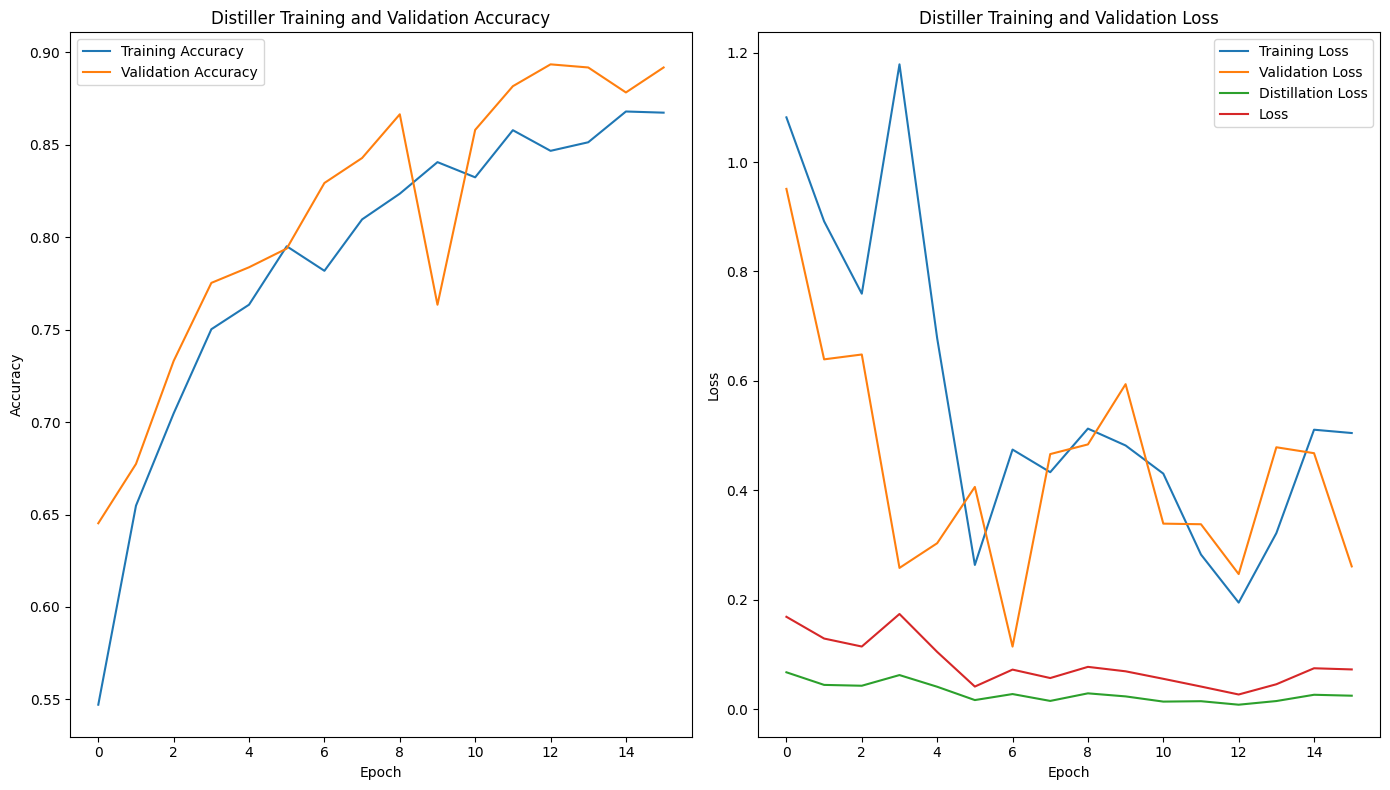

NameError: name 'extract_data' is not defined

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(distiller_history2.history['accuracy'], label='Training Accuracy')
plt.plot(distiller_history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Distiller Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(distiller_history2.history['student_loss'], label='Training Loss')
plt.plot(distiller_history2.history['val_student_loss'], label='Validation Loss')
plt.plot(distiller_history2.history['distillation_loss'], label='Distillation Loss')
plt.plot(distiller_history2.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Distiller Training and Validation Loss')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()



import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Extract data for distiller
x_distiller, y_distiller = extract_data(test_set)


# Predictions on distiller set
distiller_predictions = distiller2.predict(x_distiller)

# Convert one-hot encoded labels to categorical labels
true_distiller_labels = np.argmax(y_distiller, axis=1)
predicted_distiller_labels = np.argmax(distiller_predictions, axis=1)

# Classification Report
print("Distiller Classification Report:")
distiller_report = classification_report(true_distiller_labels, predicted_distiller_labels)
print(distiller_report)

# Confusion Matrix
distiller_conf_matrix = confusion_matrix(true_distiller_labels, predicted_distiller_labels)
print("\nDistiller Confusion Matrix:")
print(distiller_conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(distiller_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Distiller Confusion matrix')
plt.colorbar()

# Assuming label_dict is the same for the student and distiller models
classes_distiller = list(label_dict.values())
tick_marks_distiller = np.arange(len(classes_distiller))
plt.xticks(tick_marks_distiller, classes_distiller, rotation=45)
plt.yticks(tick_marks_distiller, classes_distiller)

# Print the confusion matrix values on each cell
for i in range(len(classes_distiller)):
    for j in range(len(classes_distiller)):
        plt.text(j, i, str(distiller_conf_matrix[i, j]), ha='center', va='center', color='red' if i != j else 'white')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Random predictions for the distiller model
plt.figure(figsize=(28, 12))
for i, index in enumerate(np.random.choice(x_distiller.shape[0], size=24)):
    ax = plt.subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_distiller[index]))
    predict_index = label_dict[predicted_distiller_labels[index]]
    true_index = label_dict[true_distiller_labels[index]]

    ax.set_title("{} ({})".format(predict_index, true_index),
                 color=("green" if predict_index == true_index else "red"))

# Show the random predictions
plt.show()


In [12]:
student_scratch.evaluate(test_set)
student_scratch.save('CNNbasedTeacher_distil2_T10.h5')

19/19 [==============================] - 2s 72ms/step - loss: 0.2583 - accuracy: 0.9076


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
import json

# Evaluate student on test dataset
evaluation_results = student_scratch.evaluate(test_set)

# Save evaluation results to a JSON file
evaluation_file_path = 'CNNbasedTeacher_distil2_T10.json'
with open(evaluation_file_path, 'w') as f:
    json.dump(evaluation_results, f)

19/19 [==============================] - 1s 74ms/step - loss: 0.2583 - accuracy: 0.9076


In [14]:
import numpy as np
from tabulate import tabulate

# Function to calculate MSE and RMSE
def calculate_errors(model_name, model, test_set):
    print("Calculating errors for", model_name, "model...")
    # Evaluate the model on the test set
    loss, _ = model.evaluate(test_set)
    print("Model Loss:", loss)

    num_samples = len(test_set)
    mse_total = 0.0

    for _ in range(num_samples):
        # Get batch of test data
        X_test_batch, y_test_batch = test_set.next()

        # Make predictions using the model
        predictions_batch = model.predict(X_test_batch)

        # Calculate Mean Squared Error for this batch
        mse_batch = np.mean(np.square(predictions_batch - y_test_batch))

        # Add to total MSE
        mse_total += mse_batch

    # Calculate average MSE across all batches
    mse = mse_total / num_samples
    print("Mean Squared Error:", mse)

    # Calculate RMSE
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error:", rmse)
    return loss, mse, rmse

# Load and calculate errors for the teacher model
teacher_model = teacher
teacher_loss, teacher_mse, teacher_rmse = calculate_errors("Teacher", teacher_model, test_set)

# Load and calculate errors for the student model
student_model = student
student_loss, student_mse, student_rmse = calculate_errors("Student", student_model, test_set)

# Load and calculate errors for the distiller model
distiller_model = student_scratch
distiller_loss, distiller_mse, distiller_rmse = calculate_errors("Distiller", distiller_model, test_set)

# Calculate differences between student and distiller MSE and RMSE
mse_difference = distiller_mse - student_mse
rmse_difference = distiller_rmse - student_rmse

# Create table
table = [
    ["Teacher", teacher_loss, teacher_mse, teacher_rmse],
    ["Student", student_loss, student_mse, student_rmse],
    ["Distiller", distiller_loss, distiller_mse, distiller_rmse],
    ["Difference", "", mse_difference, rmse_difference]
]
print(tabulate(table, headers=["Model", "Loss", "MSE", "RMSE"], tablefmt="grid"))



Calculating errors for Teacher model...
19/19 [==============================] - 2s 80ms/step - loss: 0.0710 - accuracy: 0.9916
Model Loss: 0.07100679725408554
1/1 [==============================] - 0s 96ms/step
Mean Squared Error: 0.00801728688805413
Root Mean Squared Error: 0.08953930359375223
Calculating errors for Student model...
19/19 [==============================] - 2s 101ms/step - loss: 0.4975 - accuracy: 0.8000
Model Loss: 0.49750474095344543
1/1 [==============================] - 0s 89ms/step
Mean Squared Error: 0.0712879623629545
Root Mean Squared Error: 0.2669980568523945
Calculating errors for Distiller model...
19/19 [==============================] - 1s 71ms/step - loss: 0.2583 - accuracy: 0.9076
Model Loss: 0.258327841758728
1/1 [==============================] - 0s 71ms/step
Mean Squared Error: 0.03622294732026363
Root Mean Squared Error: 0.19032327056948037
+------------+---------------------+-------------+------------+
| Model      | Loss                |         M